For this analysis, we will find the customer lifetime value for buyers of a specific brand.

In [1]:
import sys
import pandas as pd
import numpy as np
import pymysql.cursors
import argparse
import datetime 
import configparser
import itertools

config= configparser.ConfigParser()
config.read('db.ini')
dbhost = config.get('database','dbhost')
username = config.get('database','username')
port = config.get('database','port')
password = config.get('database','password')
dbname = config.get('database','dbname')
ssl_cert = config.get('database','ssl_cert')

#print(dbname)
conn= pymysql.connect(host= dbhost,
                                 port= int(port),
                                 user= username,
                                 password= password,
                                 db= dbname ,
                                 charset='utf8mb4',
                                 ssl={'ssl':{'ca' : ssl_cert }},
                                 cursorclass=pymysql.cursors.DictCursor)

cur = conn.cursor()
query1 = (
"""SELECT * FROM `brand_buyer_metrics` where `brandid` = '18'
""")
#query2= (

cur.execute(query1)

df = pd.DataFrame(data=cur.fetchall())
cur.close()
conn.close()

df.head()

,id,BuyerEmail,brandid,month,monthdate,total_sales,total_units,total_orders,sns_sales,sns_units,...,total_sales_with_promotion,total_units_with_promotion,total_orders_with_promotion,total_itempromotiondiscount,total_shippromotiondiscount,order_discount,first_sns_month,first_time_customer,months_since_first_purchase,updated
0,257,,18,2017-09,2017-09-01,136.900,2,2,0.000,0,...,0.000,0,0,0.00,5.10,0.00,0,1,0,2022-02-24 03:00:28
1,258,,18,2017-10,2017-10-01,598.950,12,10,0.000,0,...,0.000,0,0,0.00,5.99,0.00,0,0,1,2022-02-24 03:00:28
2,259,,18,2017-11,2017-11-01,1049.850,19,19,0.000,0,...,162.900,3,3,8.15,38.62,5.00,0,0,2,2022-02-24 03:00:28
3,260,,18,2017-12,2017-12-01,1443.500,32,27,0.000,0,...,282.300,6,6,14.13,55.09,5.01,0,0,3,2022-02-24 03:00:28
4,261,,18,2018-01,2018-01-01,669.050,15,15,0.000,0,...,0.000,0,0,0.00,3.00,0.00,0,0,4,2022-02-24 03:00:28


CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

In [2]:
df['total_sales']=df['total_sales'].astype(float)
df['total_orders']=df['total_orders'].astype(float)
test = df.groupby(['month']).agg({'total_orders': ['sum'], 'total_sales': ['sum'], 'BuyerEmail': 'count'})
test = test[0:-1] #remove the latest month since it is incomplete
test.head()

,total_orders,total_sales,BuyerEmail
,sum,sum,count
month,,,
2017-07,525.0,29073.20,513
2017-08,1197.0,62884.80,1127
2017-09,1547.0,81809.05,1453
2017-10,1951.0,102433.05,1802
2017-11,2113.0,111100.75,1915


We'll look at this metrics as a rolling 12 month average.

In [3]:
test.columns = test.columns.get_level_values(0)
test['pf'] = test['total_orders'].rolling(window=12).mean()/test['BuyerEmail'].rolling(window=12).mean() #purchase frequency
test['aov'] = test['total_sales'].rolling(window=12).mean()/test['total_orders'].rolling(window=12).mean() #average order value
test['avg_cv'] = test['pf']*test['aov'] #average customer value (for the specified period: 1 month)
test.head(15)

,total_orders,total_sales,BuyerEmail,pf,aov,avg_cv
month,,,,,,
2017-07,525.0,29073.20,513,NaN,NaN,NaN
2017-08,1197.0,62884.80,1127,NaN,NaN,NaN
2017-09,1547.0,81809.05,1453,NaN,NaN,NaN
2017-10,1951.0,102433.05,1802,NaN,NaN,NaN
2017-11,2113.0,111100.75,1915,NaN,NaN,NaN
2017-12,2354.0,123318.70,2132,NaN,NaN,NaN
2018-01,3073.0,165541.05,2814,NaN,NaN,NaN
2018-02,3352.0,181908.80,3105,NaN,NaN,NaN
2018-03,4029.0,216312.05,3728,NaN,NaN,NaN


Text(0.5, 1.0, 'Avg. CV')

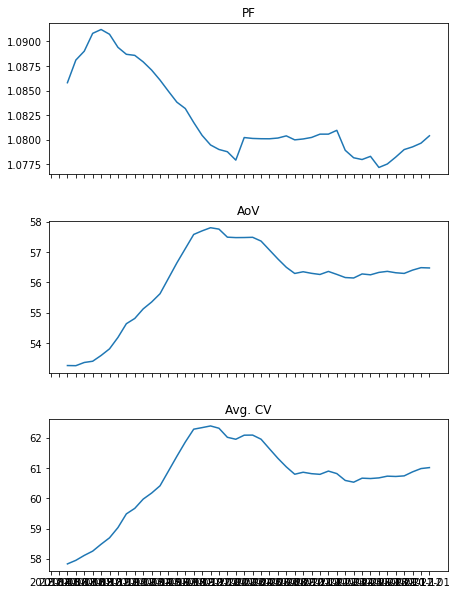

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, sharex='col')
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=1, top=2, wspace=None, hspace=None)
axs[0].plot(test.index, test['pf'])
axs[0].set_title('PF')
axs[1].plot(test.index, test['aov'])
axs[1].set_title('AoV')
axs[2].plot(test.index, test['avg_cv'])
axs[2].set_title('Avg. CV')

In [5]:
glist=df[['month', 'BuyerEmail']].values
month_ll = [] #month list of lists - this will become a list of all the unique buyer emails per month

for month in np.unique(df['month']):
    ml=[] #month list - for each month, a list of unique emails. This is appended to month_ll declared above
    for i in range(0,len(glist)):
        if glist[i][0] == month:
            ml.append(glist[i][1])
    month_ll.append(ml)

In [6]:
cm=[] #chain month - this will become a list of each month and the 12 prior months and their respective unique emails.
for i in range(0,len(month_ll)):
    chainmonth = list(itertools.chain(*month_ll[i-12:i]))
    cm.append(chainmonth)

#len(cm[25])

To determine churn rate, we will look at all the unique customers per month for the last 12 months, and compare that to the list of unique customers per month for the prior 12 months to those. We will determine how many buyers did not repeat a purchase in this 24 period timeframe and consider them lost. We will then calculate churn rate as non-repeating buyers / all buyers in that period.

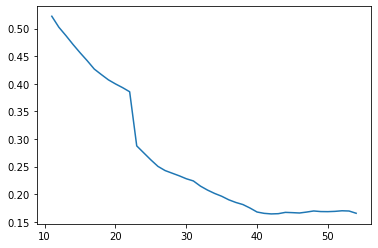

In [7]:
cr_list = [] #churn rate list

for i in range(1,len(cm)):
    no_repeats = list(set(cm[i]).difference(set(cm[i-12])))
    cust=len(cm[i])
    nr=len(no_repeats)
    if cust>0:
        cr=nr/cust
    else:
        cr=None
    cr_list.append(cr)

plt.plot(cr_list)
#cr_list

In [8]:
test['cr'] = cr_list #churn rate
test.tail(15)

,total_orders,total_sales,BuyerEmail,pf,aov,avg_cv,cr
month,,,,,,,
2020-11,7415.0,415703.72,6864,1.080238,56.297850,60.815081,0.167525
2020-12,7452.0,418047.35,6896,1.080573,56.260385,60.793476,0.165118
2021-01,8325.0,470219.80,7702,1.080574,56.359712,60.900843,0.164083
2021-02,7808.0,430996.60,7249,1.080962,56.262785,60.817935,0.164512
2021-03,8380.0,472028.05,7757,1.078929,56.159147,60.591752,0.166883
2021-04,7815.0,437042.95,7324,1.078171,56.144766,60.533631,0.166381
2021-05,8143.0,465531.70,7565,1.077991,56.277498,60.666648,0.165744
2021-06,8021.0,447238.07,7428,1.078316,56.249345,60.654559,0.167447
2021-07,7787.0,444231.75,7290,1.077184,56.328397,60.676052,0.169423


In [9]:
test['clt']=1/test['cr'] #customer lifetime. This represents the amount of specified periods (1 month in this example) a customer is expected to last on average.
test.head(15)

,total_orders,total_sales,BuyerEmail,pf,aov,avg_cv,cr,clt
month,,,,,,,,
2017-07,525.0,29073.20,513,NaN,NaN,NaN,NaN,NaN
2017-08,1197.0,62884.80,1127,NaN,NaN,NaN,NaN,NaN
2017-09,1547.0,81809.05,1453,NaN,NaN,NaN,NaN,NaN
2017-10,1951.0,102433.05,1802,NaN,NaN,NaN,NaN,NaN
2017-11,2113.0,111100.75,1915,NaN,NaN,NaN,NaN,NaN
2017-12,2354.0,123318.70,2132,NaN,NaN,NaN,NaN,NaN
2018-01,3073.0,165541.05,2814,NaN,NaN,NaN,NaN,NaN
2018-02,3352.0,181908.80,3105,NaN,NaN,NaN,NaN,NaN
2018-03,4029.0,216312.05,3728,NaN,NaN,NaN,NaN,NaN


In [10]:
test['cltv'] = (test['aov']*test['pf'])/test['cr'] #customer lifetime value
test.tail(15)

,total_orders,total_sales,BuyerEmail,pf,aov,avg_cv,cr,clt,cltv
month,,,,,,,,,
2020-11,7415.0,415703.72,6864,1.080238,56.297850,60.815081,0.167525,5.969242,363.019920
2020-12,7452.0,418047.35,6896,1.080573,56.260385,60.793476,0.165118,6.056266,368.181450
2021-01,8325.0,470219.80,7702,1.080574,56.359712,60.900843,0.164083,6.094490,371.159574
2021-02,7808.0,430996.60,7249,1.080962,56.262785,60.817935,0.164512,6.078583,369.686854
2021-03,8380.0,472028.05,7757,1.078929,56.159147,60.591752,0.166883,5.992214,363.078746
2021-04,7815.0,437042.95,7324,1.078171,56.144766,60.533631,0.166381,6.010304,363.825536
2021-05,8143.0,465531.70,7565,1.077991,56.277498,60.666648,0.165744,6.033385,366.025237
2021-06,8021.0,447238.07,7428,1.078316,56.249345,60.654559,0.167447,5.972054,362.232272
2021-07,7787.0,444231.75,7290,1.077184,56.328397,60.676052,0.169423,5.902383,358.133279


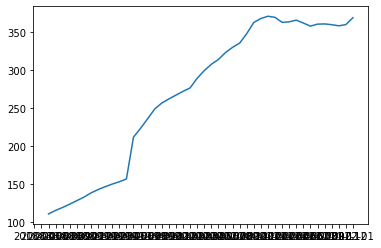

In [11]:
plt.plot(test.index, test['cltv'])

In [12]:
cltv = test['cltv'][-1]
print("CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin")
print("customer lifetime value: $",round(cltv, 2))

CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin
customer lifetime value: $ 369.2
